# Binary Classification on Tabular Data - Predicting Abnormal ECG Scans





## Introduction

In this example, you will train an autoencoder to detect anomalies on the ECG5000 dataset. This dataset contains 5,000 Electrocardiograms, each with 140 data points. You will use a simplified version of the dataset, where each example has been labeled either 0 (corresponding to an abnormal rhythm), or 1 (corresponding to a normal rhythm). You are interested in identifying the abnormal rhythms.

## Technical preliminaries


In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# initialize the seeds of different random number generators so that the 
# results will be the same every time the notebook is run
tf.random.set_seed(42)

pd.options.mode.chained_assignment = None

## Read in the data

Conveniently, the dataset in CSV form has been made available online and we can load it into a Pandas dataframe with the very useful `pd.read_csv` command.

In [2]:
#Because each column of data represents a datapoint we will name the columns by the sequence of datapoints 
# (1,2,3...140)
names = []
for i in range(140):
    names.append(i)
# The last column will be the target or dependent variable
names.append('Target')


#### Read in the data from http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv and set the column names from the list created in the box above

In [5]:
# YOUR CODE HERE
df = pd.read_csv(("http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv"), names = names)

In [6]:
df.shape

(4998, 141)

##### The dataset has 4998 rows and 141 columns (140 independent variables + 1 dependent variable):

##### Let's take a look at the first few rows:

In [7]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,Target
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818287,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490658,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


## Preprocessing 

This dataset only has numeric variables. For concistancy sake, we will assign the column names to variable numerics. 


In [8]:
numerics = names

# Remove the dependent variable
numerics.remove('Target') 

What % of the data is abnormal data?

In [9]:
# Set the output to "target_metrics"
# YOUR CODE HERE
target_metrics = df.Target.value_counts(normalize=True)
print(target_metrics)

1.0    0.584034
0.0    0.415966
Name: Target, dtype: float64


###### Extract the dependent variable 

In [10]:
#set the dependent variables to 'y'
y= df.pop('Target')



Before we normalize the numerics, let's split the data into an 80% training set and 20% test set (*why should we split **before** normalization?*).

In [11]:
from sklearn.model_selection import train_test_split

In [18]:
#split into train and test sets with the following naming conventions:
# X_train, X_test, y_train and y_test
#YOUR CODE HERE
X_train, X_test, y_train, y_test= train_test_split(df, y, test_size=0.2, stratify=y)


OK, let's calculate the mean and standard deviation of every numeric variable in the training set.

In [21]:
means = means = X_train[numerics].mean()
sd = X_train[numerics].std()

Let's normalize the train and test dataframes with these means and standard deviations.

In [22]:
# Normalize X_train
# YOUR CODE HERE
X_train[numerics]= (X_train[numerics] - means)/sd

In [23]:
# Normalize X_test
# YOUR CODE HERE
X_test[numerics]= (X_test[numerics] - means)/sd

In [24]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,138,139
1548,-0.324223,0.017476,-0.239725,-0.626366,-0.773065,-1.021625,-0.903906,0.730560,1.046068,0.431201,...,0.136258,0.097814,0.074905,-0.099340,-0.121296,0.029998,0.105706,0.225045,0.180831,-0.334431
1699,0.257813,0.018389,-0.347417,-0.887938,-1.067469,-1.079334,-0.479473,0.235783,-0.096698,-0.076907,...,0.588783,0.573320,0.406906,0.285188,0.292034,0.461352,0.846450,0.762890,0.186995,-0.817382
964,-0.773805,-0.650748,-0.319481,-0.324290,-0.707770,-1.036366,-1.105949,-0.296229,-0.170099,-0.574328,...,1.287564,0.838607,0.541872,0.241415,0.015990,-0.122720,-0.204666,-0.343417,-0.111695,-0.205665
2342,-1.765650,-1.911780,-1.466928,-0.819012,0.091862,0.922947,1.075613,0.944488,1.409581,1.021341,...,1.082611,0.862686,0.884661,0.935989,0.949462,0.841522,0.843592,1.003270,1.033259,0.166492
1219,-0.266433,-0.501421,-0.802135,-1.046027,-0.579275,0.028564,0.906853,0.728782,1.324600,1.201311,...,1.173078,0.882227,0.500253,0.420613,0.333262,0.204160,0.251804,0.387979,0.333187,-0.825415


The easiest way to feed data to Keras/Tensorflow is as Numpy arrays so we convert our two dataframes to Numpy arrays.

In [25]:
# Convert X_train and X_test to Numpy arrays
# YOUR CODE HERE
X_train = X_train .to_numpy()
X_test= X_test.to_numpy()

In [26]:
# If this box fails on a second attempt try recreating X_train and X_test and running the boxes before this. 

In [27]:
X_train.shape, y_train.shape

((3998, 140), (3998,))

In [28]:
X_test.shape, y_test.shape


((1000, 140), (1000,))

## Build a model



### Define model in Keras

Creating an NN  is usually just a few lines of Keras code. 

* We will start with a single hidden layer. 
* Since this is a *binary classification problem*, we will use a sigmoid activation in the output layer.

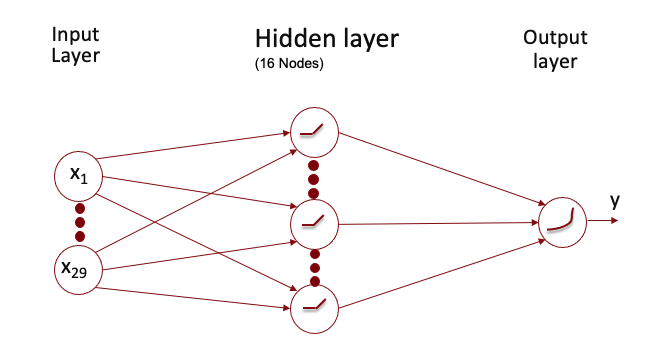

In [32]:
#get the number of columns and assign it to "num_columns"

# YOUR CODE HERE
num_columns = X_train.shape[1]

# Define the input layer. assign it to "input"

input = keras.Input(shape=num_columns)

# Feed the input vector to the hidden layer. Call it "h"
# YOUR CODE HERE
h = keras.layers.Dense(16, activation="relu", name="Hidden")(input)

# Feed the output of the hidden layer to the output layer. Call it "output"
# YOUR CODE HERE
output = keras.layers.Dense(1, activation="sigmoid", name="Output")(h)

# tell Keras that this (input,output) pair is your model. Call it "model"
# YOUR CODE HERE
model = keras.Model(input, output)

The `model.summary()` command is a good way to get a quick overview of what you have defined.

In [33]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 140)]             0         
_________________________________________________________________
Hidden (Dense)               (None, 16)                2256      
_________________________________________________________________
Output (Dense)               (None, 1)                 17        
Total params: 2,273
Trainable params: 2,273
Non-trainable params: 0
_________________________________________________________________


We can "visualize" the network graphically as well using Keras' `plot_model` function.

In [34]:
keras.utils.plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


### Set optimization parameters

Now that the model is defined, we need to tell Keras three things:

*   What **loss function** to use - Since our output variable is binary, we will select the `binary_crossentropy` loss function. 
*   Which **optimizer** to use - we will use a 'flavor' of SGD called **Adam** which is an excellent default choice 
*   What **metrics** you want Keras to report out - in classification problems like this one, Accuracy is commonly used.

In [35]:
# YOUR CODE HERE
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

## Train the model

To kickoff training, we have to decide on three things:
* The *batch size* - 32 is a good default
* The number of *epochs* i.e., how many passes through the training data. Start by setting this to 100, but you can experiment with different values.
* Whether we want to use a validation set. This will be useful for overfitting detection and regularization via early stopping so we will ask Keras to automatically use 20% of the data points as a validation set

OK, let's train the model using the `model.fit` function!

In [36]:
# Fit your model and assign the output to "history"
# YOUR CODE HERE
history = model.fit(train_X,
                    train_y,
                    epochs=300,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/300
100/100 [==============================] - 1s 4ms/step - loss: 0.1391 - accuracy: 0.9612 - val_loss: 0.0620 - val_accuracy: 0.9837
Epoch 2/300
100/100 [==============================] - 0s 2ms/step - loss: 0.0547 - accuracy: 0.9837 - val_loss: 0.0401 - val_accuracy: 0.9837
Epoch 3/300
100/100 [==============================] - 0s 2ms/step - loss: 0.0398 - accuracy: 0.9894 - val_loss: 0.0302 - val_accuracy: 0.9862
Epoch 4/300
100/100 [==============================] - 0s 2ms/step - loss: 0.0339 - accuracy: 0.9909 - val_loss: 0.0244 - val_accuracy: 0.9912
Epoch 5/300
100/100 [==============================] - 0s 2ms/step - loss: 0.0281 - accuracy: 0.9931 - val_loss: 0.0237 - val_accuracy: 0.9912
Epoch 6/300
100/100 [==============================] - 0s 2ms/step - loss: 0.0253 - accuracy: 0.9941 - val_loss: 0.0212 - val_accuracy: 0.9925
Epoch 7/300
100/100 [==============================] - 0s 2ms/step - loss: 0.0234 - accuracy: 0.9934 - val_loss: 0.0196 - val_accuracy: 0.9937

Epoch 58/300
100/100 [==============================] - 0s 2ms/step - loss: 0.0046 - accuracy: 0.9987 - val_loss: 0.0455 - val_accuracy: 0.9912
Epoch 59/300
100/100 [==============================] - 0s 2ms/step - loss: 0.0049 - accuracy: 0.9984 - val_loss: 0.0468 - val_accuracy: 0.9900
Epoch 60/300
100/100 [==============================] - 0s 2ms/step - loss: 0.0042 - accuracy: 0.9987 - val_loss: 0.0442 - val_accuracy: 0.9900
Epoch 61/300
100/100 [==============================] - 0s 2ms/step - loss: 0.0050 - accuracy: 0.9981 - val_loss: 0.0428 - val_accuracy: 0.9900
Epoch 62/300
100/100 [==============================] - 0s 2ms/step - loss: 0.0048 - accuracy: 0.9987 - val_loss: 0.0589 - val_accuracy: 0.9900
Epoch 63/300
100/100 [==============================] - 0s 2ms/step - loss: 0.0068 - accuracy: 0.9978 - val_loss: 0.0332 - val_accuracy: 0.9912
Epoch 64/300
100/100 [==============================] - 0s 2ms/step - loss: 0.0044 - accuracy: 0.9991 - val_loss: 0.0447 - val_accuracy:

100/100 [==============================] - 0s 2ms/step - loss: 7.2895e-04 - accuracy: 1.0000 - val_loss: 0.0746 - val_accuracy: 0.9887
Epoch 115/300
100/100 [==============================] - 0s 2ms/step - loss: 6.7091e-04 - accuracy: 1.0000 - val_loss: 0.0739 - val_accuracy: 0.9887
Epoch 116/300
100/100 [==============================] - 0s 2ms/step - loss: 7.6697e-04 - accuracy: 0.9997 - val_loss: 0.0733 - val_accuracy: 0.9887
Epoch 117/300
100/100 [==============================] - 0s 2ms/step - loss: 8.4902e-04 - accuracy: 1.0000 - val_loss: 0.0802 - val_accuracy: 0.9887
Epoch 118/300
100/100 [==============================] - 0s 2ms/step - loss: 8.9115e-04 - accuracy: 0.9997 - val_loss: 0.0779 - val_accuracy: 0.9912
Epoch 119/300
100/100 [==============================] - 0s 2ms/step - loss: 0.0056 - accuracy: 0.9975 - val_loss: 0.0832 - val_accuracy: 0.9850
Epoch 120/300
100/100 [==============================] - 0s 2ms/step - loss: 0.0069 - accuracy: 0.9966 - val_loss: 0.0584 - 

100/100 [==============================] - 0s 2ms/step - loss: 2.9868e-04 - accuracy: 1.0000 - val_loss: 0.0873 - val_accuracy: 0.9887
Epoch 170/300
100/100 [==============================] - 0s 2ms/step - loss: 2.9065e-04 - accuracy: 1.0000 - val_loss: 0.0853 - val_accuracy: 0.9887
Epoch 171/300
100/100 [==============================] - 0s 2ms/step - loss: 3.5026e-04 - accuracy: 1.0000 - val_loss: 0.0885 - val_accuracy: 0.9887
Epoch 172/300
100/100 [==============================] - 0s 2ms/step - loss: 2.9884e-04 - accuracy: 1.0000 - val_loss: 0.0887 - val_accuracy: 0.9887
Epoch 173/300
100/100 [==============================] - 0s 2ms/step - loss: 2.8802e-04 - accuracy: 1.0000 - val_loss: 0.0904 - val_accuracy: 0.9887
Epoch 174/300
100/100 [==============================] - 0s 2ms/step - loss: 3.1474e-04 - accuracy: 1.0000 - val_loss: 0.0927 - val_accuracy: 0.9887
Epoch 175/300
100/100 [==============================] - 0s 2ms/step - loss: 3.8969e-04 - accuracy: 1.0000 - val_loss: 0

100/100 [==============================] - 0s 2ms/step - loss: 1.4009e-04 - accuracy: 1.0000 - val_loss: 0.0800 - val_accuracy: 0.9900
Epoch 225/300
100/100 [==============================] - 0s 2ms/step - loss: 1.3931e-04 - accuracy: 1.0000 - val_loss: 0.0821 - val_accuracy: 0.9900
Epoch 226/300
100/100 [==============================] - 0s 2ms/step - loss: 1.4316e-04 - accuracy: 1.0000 - val_loss: 0.0818 - val_accuracy: 0.9900
Epoch 227/300
100/100 [==============================] - 0s 2ms/step - loss: 1.4082e-04 - accuracy: 1.0000 - val_loss: 0.0811 - val_accuracy: 0.9900
Epoch 228/300
100/100 [==============================] - 0s 2ms/step - loss: 1.2673e-04 - accuracy: 1.0000 - val_loss: 0.0809 - val_accuracy: 0.9900
Epoch 229/300
100/100 [==============================] - 0s 2ms/step - loss: 1.2511e-04 - accuracy: 1.0000 - val_loss: 0.0822 - val_accuracy: 0.9887
Epoch 230/300
100/100 [==============================] - 0s 2ms/step - loss: 1.2441e-04 - accuracy: 1.0000 - val_loss: 0

100/100 [==============================] - 0s 2ms/step - loss: 9.3060e-05 - accuracy: 1.0000 - val_loss: 0.0761 - val_accuracy: 0.9900
Epoch 280/300
100/100 [==============================] - 0s 2ms/step - loss: 9.1047e-05 - accuracy: 1.0000 - val_loss: 0.0764 - val_accuracy: 0.9900
Epoch 281/300
100/100 [==============================] - 0s 2ms/step - loss: 8.9884e-05 - accuracy: 1.0000 - val_loss: 0.0766 - val_accuracy: 0.9900
Epoch 282/300
100/100 [==============================] - 0s 2ms/step - loss: 9.0082e-05 - accuracy: 1.0000 - val_loss: 0.0763 - val_accuracy: 0.9900
Epoch 283/300
100/100 [==============================] - 0s 2ms/step - loss: 8.9864e-05 - accuracy: 1.0000 - val_loss: 0.0770 - val_accuracy: 0.9900
Epoch 284/300
100/100 [==============================] - 0s 2ms/step - loss: 9.0671e-05 - accuracy: 1.0000 - val_loss: 0.0783 - val_accuracy: 0.9900
Epoch 285/300
100/100 [==============================] - 0s 2ms/step - loss: 9.3697e-05 - accuracy: 1.0000 - val_loss: 0

Let's plot the training and loss curves to see if ***overfitting*** is going on and if **early stopping** may be needed.

In [37]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

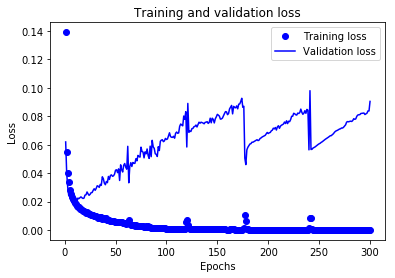

In [38]:
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


Let's look at the accuracy curves as well.



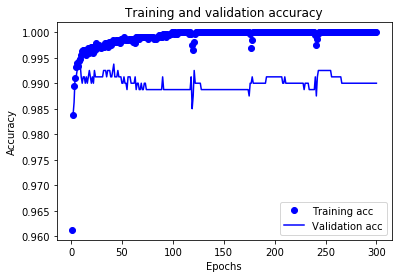

In [39]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**Do you think there's overfitting?**

If you think there's overfitting at epoch N, we could go back, re-initialize the model and just run it for  N epochs - that would an example of **early stopping**.

I invite you to try exactly that and compare to the test set accuracy calculated below. Perhaps you can do better!

## Evaluate the model

Let's see **how well the model does on the test set**. 

`model.evaluate` is a very handy function to calculate the performance of your model on any dataset.

In [40]:
# Getting the results of your model for grading
score, acc = model.evaluate(X_test, y_test)

32/32 [==============================] - 0s 1ms/step - loss: 0.0521 - accuracy: 0.9960


In [41]:
### This box will pass if your accuracy is over 97%

To assess if this accuracy number is impressive, we can compare it the accuracy of a simple, baseline model. 

What's a reasonable baseline model?

In [42]:
y.value_counts(normalize=True)

1.0    0.584034
0.0    0.415966
Name: Target, dtype: float64

If we predict 0 for every point, the accuracy will be 41.6%. So the 98.2% accuracy from our DL model is excellent!!
